In [8]:
from unstructured.partition.pdf import partition_pdf
from unstructured.chunking.title import chunk_by_title
import json

file_path = "./content/attention.pdf"

# Step 1: Extract all elements without chunking
elements = partition_pdf(
    filename=file_path,
    strategy="hi_res",
    infer_table_structure=True,
    extract_images_in_pdf=True,
    extract_image_block_types=["Image"],
    extract_image_block_to_payload=True
)

# Step 2: Separate tables/images from text elements
image_chunks = [el for el in elements if el.category in [ "Image"]]
table_chunks = [el for el in elements if el.category in ["Table"]]
text_elements = [el for el in elements if el.category not in ["Table", "Image"]]

# Step 3: Apply chunking only to the text elements
chunked_text = chunk_by_title(
    text_elements,
    max_characters=10000,
    combine_text_under_n_chars=2000,
    new_after_n_chars=6000
)              

/Users/zaidnadaf/Desktop/projects/multimodal-rag-python/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to M

In [16]:

def get_images_base64(image_chunks):
    images_b64 = []
    for image_chunk in image_chunks:
        images_b64.append(image_chunk.metadata.image_base64)
    return images_b64

b64_images = get_images_base64(image_chunks)
print(b64_images)

# print(images[0].metadata.image_base64)

['/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAOAAmADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD3+iiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK5OTxVqWp6pdWPhjSI75LSQw3N/d3PkW6yjrGpCszsO

In [26]:
from IPython.display import HTML, Markdown, display

In [9]:
import htmltabletomd


def table_html_to_markdown(table_chunks):
    md_tables = []
    for table_chunk in table_chunks:
        md_table = htmltabletomd.convert_table(table_chunk.metadata.text_as_html)
        md_tables.append(md_table)
    return md_tables

md_tables = table_html_to_markdown(table_chunks)


In [40]:
%pip install python-dotenv

You should consider upgrading via the '/Users/zaidnadaf/Desktop/projects/multimodal-rag-python/venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [10]:
from langchain_openai import AzureChatOpenAI
from dotenv import load_dotenv
import os

load_dotenv()

endpoint = os.getenv("ENDPOINT_URL")  
deployment = os.getenv("DEPLOYMENT_NAME")  
subscription_key = os.getenv("AZURE_OPENAI_API_KEY")  

# Initialize Azure OpenAI Service client with key-based authentication    
model = AzureChatOpenAI(  
    azure_endpoint=endpoint,  
    api_key=subscription_key,  
    api_version="2024-05-01-preview",
    model=deployment
)

In [ ]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate

# Prompt
prompt_text = """
You are an assistant tasked with summarizing tables and text particularly for semantic retrieval.
These summaries will be embedded and used to retrieve the raw text or table elements
Give a detailed summary of the table or text below that is well optimized for retrieval.
For any tables also add in a one line description of what the table is about besides the summary.
Do not add additional words like Summary: etc.
Table or text chunk:
{element}
"""
prompt = ChatPromptTemplate.from_template(prompt_text)

# Summary chain
summarize_chain = (
    {"element": lambda x: x}  
    | prompt
    | model
    | StrOutputParser()  # extracts the response as text and returns it as a string
)

try:
    table_summaries = summarize_chain.batch(md_tables, {"max_concurrency": 5})
    text_summaries = summarize_chain.batch(chunked_text,{"max_concurrency":5})
except Exception as e:
    print(f"Batch processing error: {e}")

In [19]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
import time

# Image summarization prompt
image_prompt_text = """
You are an assistant tasked with summarizing images particularly for semantic retrieval.
These summaries will be embedded and used to retrieve the original images.
Give a detailed summary of the image below that is well optimized for retrieval.
Include a one-line description of what the image is about besides the summary.
Describe key visual elements, colors, composition, subjects, and any text visible in the image.
Do not add additional words like "Summary:" etc.

Image (base64 encoded):
{image}
"""
image_prompt = ChatPromptTemplate.from_template(image_prompt_text)

# Image summary chain
image_summarize_chain = (
    {"image": lambda x: x}
    | image_prompt
    | model
    | StrOutputParser()
)

# Process images with rate limiting
def process_images_with_rate_limit(images, delay=2.0):
    summaries = []
    for i, img in enumerate(images):
        try:
            print(f"Processing image {i+1}/{len(images)}...")
            summary = image_summarize_chain.invoke(img)
            summaries.append(summary)
            
            # Add delay between requests to avoid rate limits
            if i < len(images) - 1:  # No need to sleep after the last image
                print(f"Waiting {delay} seconds before next request...")
                time.sleep(delay)
                
        except Exception as e:
            print(f"Error processing image {i+1}: {e}")
            # Add longer backoff if we hit an error
            print(f"Backing off for 10 seconds...")
            time.sleep(10)
            # Try again with the same image
            try:
                print(f"Retrying image {i+1}...")
                summary = image_summarize_chain.invoke(img)
                summaries.append(summary)
                time.sleep(delay)
            except Exception as e2:
                print(f"Failed retry for image {i+1}: {e2}")
                summaries.append(f"Failed to process: {str(e2)}")
    
    return summaries

# Use this instead of batch processing
image_summaries = process_images_with_rate_limit(b64_images, delay=3.0)

Processing image 1/3...


KeyboardInterrupt: 

In [20]:
from langchain_openai import ChatOpenAI

prompt_template = """Describe the image in detail. For context,
                  the image is part of a research paper explaining the transformers
                  architecture. Be specific about graphs, such as bar plots."""
messages = [
    (
        "user",
        [
            {"type": "text", "text": prompt_template},
            {
                "type": "image_url",
                "image_url": {"url": "data:image/jpeg;base64,{image}"},
            },
        ],
    )
]

prompt = ChatPromptTemplate.from_messages(messages)

chain = prompt | model | StrOutputParser()


image_summaries = chain.batch(b64_images)

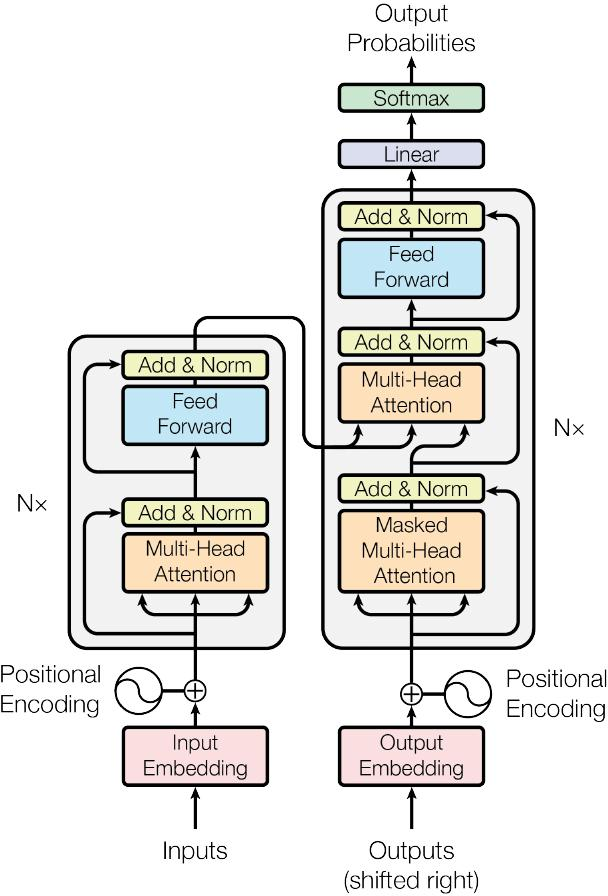

In [26]:
import base64
from IPython.display import Image, display

def display_base64_image(base64_image):
    base64_decode = base64.b64decode(base64_image)

    display(Image(data=base64_decode))

display_base64_image(b64_images[0])

In [21]:
print(image_summaries[0])

The image is a detailed diagram illustrating the architecture of a Transformer model as described in the "Attention Is All You Need" research paper. The diagram visually represents both the encoder and decoder components of the Transformer, highlighting key operations and structural flow. Here is a breakdown of the elements depicted in the image:

---

### **Encoder (Left Side):**
1. **Input Embedding:**
   - Represented as a rectangular pink box labeled **"Input Embedding"**. It processes the input tokens into a dense vector representation.

2. **Positional Encoding:**
   - The positional encoding is added to the input embeddings, shown as a circular node with a ⊕ symbol. This is used to inject positional information into the input embeddings.

3. **Multi-Head Attention (Inside Encoder Layer):**
   - The first operation within the encoder layer is multi-head self-attention. It is represented by a box labeled **"Multi-Head Attention"** with a light orange background.

4. **Add & Norm:*

In [76]:
%pip install uuid

31334.08s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Using legacy 'setup.py install' for uuid, since package 'wheel' is not installed.
    Running setup.py install for uuid ... done
You should consider upgrading via the '/Users/zaidnadaf/Desktop/projects/multimodal-rag-python/venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [28]:
from langchain_openai import AzureOpenAIEmbeddings
from dotenv import load_dotenv
import os

load_dotenv()

endpoint = os.getenv("ENDPOINT_URL")
model_name = os.getenv("EMBEDDING_DEPLOYMENT")
subscription_key=os.getenv("AZURE_OPENAI_API_KEY")

api_version = "2024-12-01-preview"



openai_embed_model = AzureOpenAIEmbeddings(
    model="text-embedding-3-large",
    azure_endpoint=endpoint,
    api_key=subscription_key,
    api_version="2024-05-01-preview",)

In [5]:
from langchain.embeddings import AzureOpenAIEmbeddings

# Sample text to generate embeddings for
test_text = "Hello, world! Testing Azure OpenAI Embeddings."

# Generate the embeddings
try:
    embedding = openai_embed_model.embed_query(test_text)
    print("Embedding generated successfully:")
    print(embedding[:10])  # Print only the first 10 values for brevity
except Exception as e:
    print(f"Error generating embedding: {e}")


Embedding generated successfully:
[-0.007188694551587105, 0.0054673547856509686, -0.012871673330664635, -0.0068049561232328415, 0.008310671895742416, -0.014282368123531342, 0.004539073910564184, 0.05967310816049576, 0.011775278486311436, -0.001589772291481495]


In [ ]:
import os
import base64
from openai import AzureOpenAI
from dotenv import load_dotenv
import os

load_dotenv()

endpoint = os.getenv("ENDPOINT_URL")  
deployment = os.getenv("DEPLOYMENT_NAME")  
subscription_key = os.getenv("AZURE_OPENAI_API_KEY")  

# Initialize Azure OpenAI Service client with key-based authentication
client = AzureOpenAI(  
    azure_endpoint=endpoint,  
    api_key=subscription_key,  
    api_version="2024-05-01-preview",
)

def get_image_summary(image_path):
    """
    Generate a summary description of an image using Azure OpenAI's vision capabilities.
    
    Args:
        image_path (str): Path to the image file
    
    Returns:
        str: Summary description of the image
    """
    # Read and encode the image
    with open(image_path, "rb") as image_file:
        base64_image = base64.b64encode(image_file.read()).decode('ascii')
    
    # Create the message with the image
    messages = [
        {
            "role": "system",
            "content": "You are a helpful assistant that can describe images accurately and concisely."
        },
        {
            "role": "user",
            "content": [
                {
                    "type": "text", 
                    "text": "Please provide a detailed summary of this image."
                },
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpeg;base64,{base64_image}"
                    }
                }
            ]
        }
    ]
    
    # Send the request to the model
    response = client.chat.completions.create(
        model=deployment,
        messages=messages,
        max_tokens=300
    )
    
    # Extract and return the summary
    return response.choices[0].message.content

if __name__ == "__main__":
    # Example usage
    image_path = "figures/figure-4-3.jpg"  # Replace with your image path
    summary = get_image_summary(image_path)
    print("Image Summary:")
    print(summary)

Image Summary:
This diagram illustrates the mechanism of multi-head attention, commonly used in transformer models. It outlines the process of combining input queries (Q), keys (K), and values (V) for attention computation.

1. **Input Layers**: The inputs (Q, K, V) are processed through separate linear layers at the bottom.
2. **Scaled Dot-Product Attention**: The processed Q, K, V are then fed into the "Scaled Dot-Product Attention" module (in purple), which computes attention scores and refines the values based on their importance, determined by the query-key interaction.
3. **Multi-Head Attention**: The diagram shows multiple stacked layers of the attention mechanism (indicated by the overlapping shapes), representing how multiple attention heads are computed in parallel with unique transformations for deeper context understanding.
4. **Concat Operation**: The attention outputs from all heads are concatenated (yellow block labeled "Concat").
5. **Linear Transformation**: Finally, t

In [29]:
%pip install faiss-cpu

  Using cached faiss_cpu-1.10.0-cp39-cp39-macosx_11_0_arm64.whl (3.2 MB)
You should consider upgrading via the '/Users/zaidnadaf/Desktop/projects/multimodal-rag-python/venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [35]:
import uuid
from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain_community.vectorstores import FAISS
from langchain.storage import InMemoryStore
from langchain_core.documents import Document


# Initialize in-memory document store
memory_store = InMemoryStore()

def create_multi_vector_retriever(
    docstore, text_summaries, texts, table_summaries, tables, image_summaries, 
    images
):
    """
    Create retriever that indexes summaries, but returns raw images or texts
    Assumes everything is kept in memory for local testing
    """
    id_key = "doc_id"
    
    # Prepare all summaries for initial FAISS creation
    all_summaries = []
    all_metadata = []
    
    # Helper function to prepare documents
    def prepare_documents(doc_summaries, doc_contents, doc_store):
        doc_ids = [str(uuid.uuid4()) for _ in doc_contents]
        summaries = []
        metadata = []
        
        for i, s in enumerate(doc_summaries):
            summaries.append(s)
            metadata.append({id_key: doc_ids[i]})
            
        # Store the actual documents
        doc_store.mset(list(zip(doc_ids, doc_contents)))
        
        return summaries, metadata
    
    # Prepare all document types if they exist
    if text_summaries:
        text_summaries_list, text_metadata = prepare_documents(text_summaries, texts, docstore)
        all_summaries.extend(text_summaries_list)
        all_metadata.extend(text_metadata)
        
    if table_summaries:
        table_summaries_list, table_metadata = prepare_documents(table_summaries, tables, docstore)
        all_summaries.extend(table_summaries_list)
        all_metadata.extend(table_metadata)
        
    if image_summaries:
        image_summaries_list, image_metadata = prepare_documents(image_summaries, images, docstore)
        all_summaries.extend(image_summaries_list)
        all_metadata.extend(image_metadata)
    
    # Create FAISS index from all prepared summaries
    if all_summaries:
        vectorstore = FAISS.from_texts(
            texts=all_summaries,
            embedding=openai_embed_model,
            metadatas=all_metadata
        )
    else:
        # Create empty FAISS index if no documents
        vectorstore = FAISS.from_texts(
            texts=["placeholder"],
            embedding=openai_embed_model,
            metadatas=[{id_key: "placeholder"}]
        )
    
    # Create the multi-vector retriever
    retriever = MultiVectorRetriever(
        vectorstore=vectorstore,
        docstore=docstore,
        id_key=id_key,
    )
    
    return retriever

# Create the in-memory retriever
retriever_multi_vector = create_multi_vector_retriever(
    memory_store,
    text_summaries,
    chunked_text,
    table_summaries,
    md_tables,
    image_summaries,
    b64_images, 
)

In [107]:
query = "Maximum path lengths, per-layer complexity and minimum number of sequential operations for different layer types."
docs = retriever_multi_vector.invoke(query, limit=5)

# We get 3 docs
len(docs)

4

In [94]:
docs[0]

'/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAOAAmADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD3+iiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK5OTxVqWp6pdWPhjSI75LSQw3N/d3PkW6yjrGpCszsOh

In [92]:
import re
import base64

def looks_like_base64(sb):
    """Check if the string looks like base64"""
    return re.match("^[A-Za-z0-9+/]+[=]{0,2}$", sb) is not None


def is_image_data(b64data):
    """
    Check if the base64 data is an image by looking at the start of the data
    """
    image_signatures = {
        b"\xff\xd8\xff": "jpg",
        b"\x89\x50\x4e\x47\x0d\x0a\x1a\x0a": "png",
        b"\x47\x49\x46\x38": "gif",
        b"\x52\x49\x46\x46": "webp",
    }
    try:
        header = base64.b64decode(b64data)[:8]  # Decode and get the first 8 bytes
        for sig, format in image_signatures.items():
            if header.startswith(sig):
                return True
        return False
    except Exception:
        return False

In [99]:
# is_image_data(docs[0])
looks_like_base64(docs[0])

True

In [109]:
from IPython.display import Markdown
from unstructured.documents.elements import CompositeElement


retrieved_tables = []
retrieved_images = []
retrieved_texts = []

for doc in docs:
    if type(doc) == CompositeElement:
        retrieved_texts.append(str(doc))
    elif is_image_data(doc) and looks_like_base64(doc):
        retrieved_images.append(doc)
    else:
        retrieved_tables.append(doc) 


In [90]:
print(len(retrieved_texts))

2


In [110]:
for retrieved_text in retrieved_texts:
    display(Markdown(retrieved_text))
for retrieved_table in retrieved_tables:
    display(Markdown(retrieved_table))
for retrieved_image in retrieved_images:
    display_base64_image(retrieved_image)

3.5 Positional Encoding

Since our model contains no recurrence and no convolution, in order for the model to make use of the order of the sequence, we must inject some information about the relative or absolute position of the tokens in the sequence. To this end, we add "positional encodings" to the input embeddings at the

5

Table 1: Maximum path lengths, per-layer complexity and minimum number of sequential operations for different layer types. n is the sequence length, d is the representation dimension, k is the kernel size of convolutions and r the size of the neighborhood in restricted self-attention.

bottoms of the encoder and decoder stacks. The positional encodings have the same dimension dmodel as the embeddings, so that the two can be summed. There are many choices of positional encodings, learned and ﬁxed [8].

In this work, we use sine and cosine functions of different frequencies:

PE(pos,2i) = sin(pos/100002i/dmodel) PE(pos,2i+1) = cos(pos/100002i/dmodel)

where pos is the position and i is the dimension. That is, each dimension of the positional encoding corresponds to a sinusoid. The wavelengths form a geometric progression from 2π to 10000 · 2π. We chose this function because we hypothesized it would allow the model to easily learn to attend by relative positions, since for any ﬁxed offset k, PEpos+k can be represented as a linear function of PEpos.

We also experimented with using learned positional embeddings [8] instead, and found that the two versions produced nearly identical results (see Table 3 row (E)). We chose the sinusoidal version because it may allow the model to extrapolate to sequence lengths longer than the ones encountered during training.

4 Why Self-Attention

In this section we compare various aspects of self-attention layers to the recurrent and convolu- tional layers commonly used for mapping one variable-length sequence of symbol representations (x1,...,xn) to another sequence of equal length (z1,...,zn), with xi,zi ∈ Rd, such as a hidden layer in a typical sequence transduction encoder or decoder. Motivating our use of self-attention we consider three desiderata.

One is the total computational complexity per layer. Another is the amount of computation that can be parallelized, as measured by the minimum number of sequential operations required.

The third is the path length between long-range dependencies in the network. Learning long-range dependencies is a key challenge in many sequence transduction tasks. One key factor affecting the ability to learn such dependencies is the length of the paths forward and backward signals have to traverse in the network. The shorter these paths between any combination of positions in the input and output sequences, the easier it is to learn long-range dependencies [11]. Hence we also compare the maximum path length between any two input and output positions in networks composed of the different layer types.

As noted in Table 1, a self-attention layer connects all positions with a constant number of sequentially executed operations, whereas a recurrent layer requires O(n) sequential operations. In terms of computational complexity, self-attention layers are faster than recurrent layers when the sequence length n is smaller than the representation dimensionality d, which is most often the case with sentence representations used by state-of-the-art models in machine translations, such as word-piece [31] and byte-pair [25] representations. To improve computational performance for tasks involving very long sequences, self-attention could be restricted to considering only a neighborhood of size r in

6

the input sequence centered around the respective output position. This would increase the maximum path length to O(n/r). We plan to investigate this approach further in future work.

A single convolutional layer with kernel width k < n does not connect all pairs of input and output positions. Doing so requires a stack of O(n/k) convolutional layers in the case of contiguous kernels, or O(logk(n)) in the case of dilated convolutions [15], increasing the length of the longest paths between any two positions in the network. Convolutional layers are generally more expensive than recurrent layers, by a factor of k. Separable convolutions [6], however, decrease the complexity considerably, to O(k · n · d + n · d2). Even with k = n, however, the complexity of a separable convolution is equal to the combination of a self-attention layer and a point-wise feed-forward layer, the approach we take in our model.

As side beneﬁt, self-attention could yield more interpretable models. We inspect attention distributions from our models and present and discuss examples in the appendix. Not only do individual attention heads clearly learn to perform different tasks, many appear to exhibit behavior related to the syntactic and semantic structure of the sentences.

| Layer Type | Complexity per Layer | Sequential Operations | Maximum Path Length |
| :--- | :--- | :--- | :--- |
| Self-Attention | O(n? - d) | O(1) | O(1) |
| Recurrent | O(n-d?) | O(n) | O(n) |
| Convolutional | O(k-n-d?) | olny | O(logx(n)) |
| Self-Attention (restricted) | O(r-n-d) | ol) | O(n/r) |


| Model | EN-DE | BLEU EN-FR | Training EN-DE | Cost (FLOPs) EN-FR |
| :--- | :--- | :--- | :--- | :--- |
| ByteNet 23.75 |
| Deep-Att + PosUnk |  | 39.2 |  | 1.0 - 107° |
| GNMT + RL Bi] | 24.6 | 39.92 | 2.3-10!9 | 1.4-1070 |
| ConvS2S | 25.16 | 40.46 | 9.6-10'% | 1.5-1070 |
| MoE | 26.03 | 40.56 | 2.0-10'9 | 1.2. 1079 |
| Deep-Att + PosUnk Ensemble |  | 40.4 |  | 8.0 - 107° |
| GNMT + RL Ensemble (BI | 26.30 | 41.16 | 1.8-1079 | 1.1- 1074 |
| ConvS2S Ensemble [8] | 26.36 | 41.29 | 7.7-10!9 | 1.2.10?! |
| Transformer (base model) | 27.3 | 38.1 | 3.3- | 1018 |
| Transformer (big) | 28.4 | 41.0 | 2.3. | 1019 |


|  | N- | dmodi | dir | ho | dy | dy | Parop | Ets | train steps | PPL &#124; (dev) | BLEU (dev) | params 10% |
| :--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- |
| base | &#124; 6 | 512 | 2048 | 8 | 64 | 64 | 0.1 | O01 | 100K | &#124; 4.92 | 25.8 | 65 |
| (A) |  |  |  | 1 | 512 | 512 |  |  |  | 5.29 | 24.9 |  |
|  |  |  | 4 | 128 | 128 |  |  |  | 5.00 | 25.5 |  |
|  |  |  | 16 | 32 | 32 |  |  |  | 4.91 | 25.8 |  |
|  |  |  | 32 | 16 = | 16 |  |  |  | 5.01 | 25.4 |  |
| (B) |  |  |  |  | 16 |  |  |  |  | 5.16 | 9 25.1 | 58 |
|  |  |  |  | 32 |  |  |  |  | 5.01 | 25.4 | 60 |
| (C) | 2 |  |  |  |  |  |  |  |  | 6.11 | 23.7 | 36 |
| 4 |  |  |  |  |  |  |  |  | 5.19 | 25.3 | 50 |
| 8 |  |  |  |  |  |  |  |  | 4.88 | 25.5 | 80 |
|  | 256 |  |  | 3232 |  |  |  |  | 5.75 | 24.5 | 28 |
|  | 1024 |  |  | 128 | 128 |  |  |  | 4.66 | 26.0 | 168 |
|  |  | 1024 |  |  |  |  |  |  | 5.12 | 25.4 | 53 |
|  |  | 4096 |  |  |  |  |  |  | 4.75 | 26.2 | 90 |
| () |  |  |  |  |  |  | 0.0 |  |  | 5.77 | 24.6 |  |
|  |  |  |  |  |  | 0.2 |  |  | 4.95 | 25.5 |  |
|  |  |  |  |  |  |  | 0.0 |  | 467 | 25.3 |  |
|  |  |  |  |  |  |  | 0.2 |  | 5.47 | 25.7 |  |
| (E) |  |  | positional | embedding |  | instead of | sinusoids |  |  | 4.92 | 25.7 |  |
| big | &#124; 6 | 1024 | 4096 | 16 |  |  | 0.3 |  | 300K | &#124; 4.33 | 26.4 | 213 |
